# Data Scientist Professional
## Example Practical Exam Solution

You can find the project information that accompanies this example solution in the resource center, [Practical Exam Resources](https://app.datacamp.com/certification/resource-center/practical-exam-resources).

## Data Validation
This data set has 6738 rows, 9 columns. I have validated all variables and I have not made any changes after validation. All the columns are just as described in the data dictionary:
- model: 18 models without missing values, same as the description. No cleaning is needed.
- year: 23 unique values without missing values, from 1998 to 2020, same as the description. No cleaning is needed.
- price: numeric values without missing values, same as the description. No cleaning is needed.
- transmission: 4 categories without missing values, same as the description. No cleaning is needed.
- mileage: numeric values, same as the description. No cleaning is needed.
- fuelType: 4 categories without missing values, same as the description. No cleaning is needed.
- mpg: numeric values without missing values, same as the description. No cleaning is needed.
- engineSize: 16 possible values without missing values, same as the description. No cleaning is needed.


In [1]:
# Use this cell to begin, and add as many cells as you need to complete your analysis!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import r2_score,mean_squared_error
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data/toyota.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [3]:
#validate possible 18 values
df['model'].nunique()

18

In [4]:
#validate year of manufacture from 1998 to 2020
df['year'].unique()

array([2016, 2017, 2015, 2020, 2013, 2019, 2018, 2014, 2012, 2005, 2003,
       2004, 2001, 2008, 2007, 2010, 2011, 2006, 2009, 2002, 1999, 2000,
       1998])

In [5]:
#validate four types of transmission
df['transmission'].unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

In [6]:
#validate four fuel Types
df['fuelType'].unique()

array(['Petrol', 'Other', 'Hybrid', 'Diesel'], dtype=object)

In [7]:
#validate 16 possible values in engineSize
df['engineSize'].nunique()

16

In [8]:
#validate any negative values in numeric variables
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


## Exploratory Analysis
I have investigated the target variable and features of the car, and the relationship between target variable and features. After the analysis,I decided to apply the following changes to enable modeling:
- Price: use log transformation
- Create a new ordinal variable from tax variable

### Target Variable - Price

Since we need to predict the price, the price variable would be our target variable. From the histogram on the left below, we can see there is a longer right tail. Therefore, we apply log transforamtion of the price variable, the distribution on the right below is close to normal distribution.

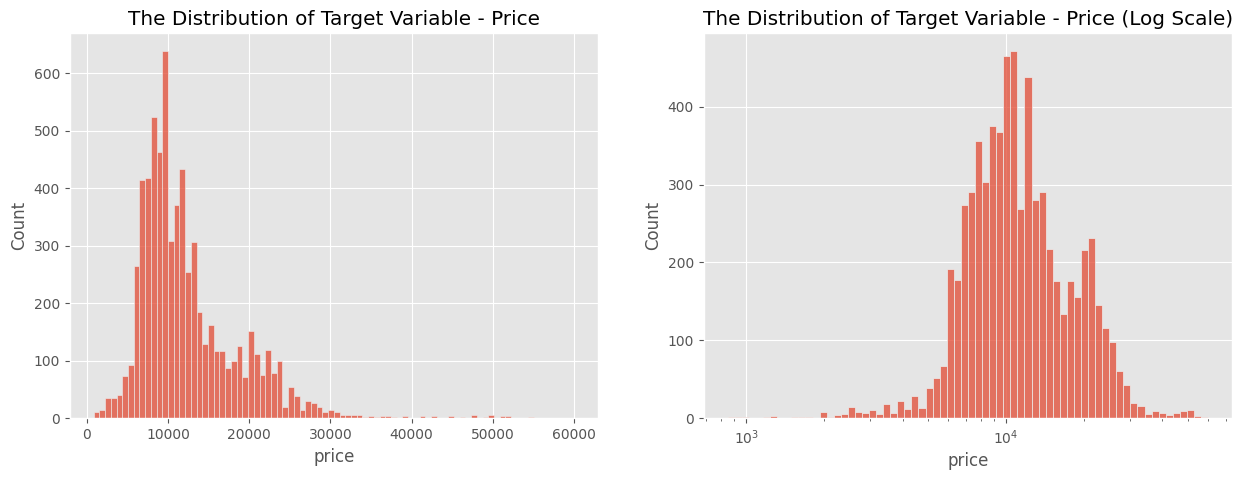

In [9]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df['price'],ax=axes[0]).set(title='The Distribution of Target Variable - Price')
sns.histplot(df['price'],log_scale=True,ax=axes[1]).set(title='The Distribution of Target Variable - Price (Log Scale)');

In [10]:
df['price'] = np.log(df['price'])

### Numeric Variables - Mileage, Tax, mpg

From the heatmap below, we can conclude that there is a moderate linear negative relationship in two pairs of variables - price log transformation and mileage, tax and mpg.

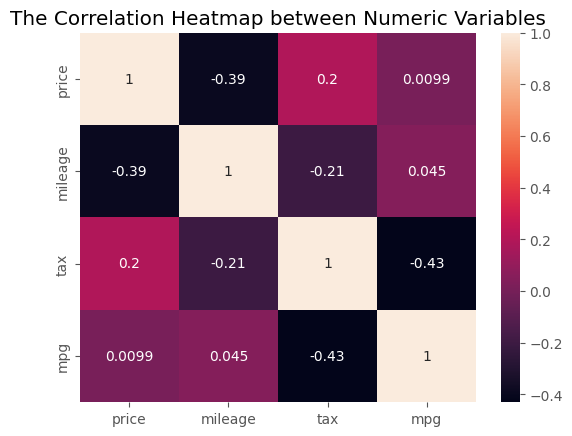

In [11]:
numeric = df[['price','mileage','tax','mpg']]
sns.heatmap(numeric.corr(),annot=True).set(title='The Correlation Heatmap between Numeric Variables');

#### Relationship between mpg, tax, mileage and price
To spot the non-linear relationship, I decided to make scatterplot to further investigate the relationship between mpg, tax, mileage and our target varible - price. From the scatterplots below, there is linear relationship between mileage and price. No relationship between price and mpg. I found out there is clusters in the scatterplot between price and tax, so I decided to create a new ordinal variable from the tax variable.

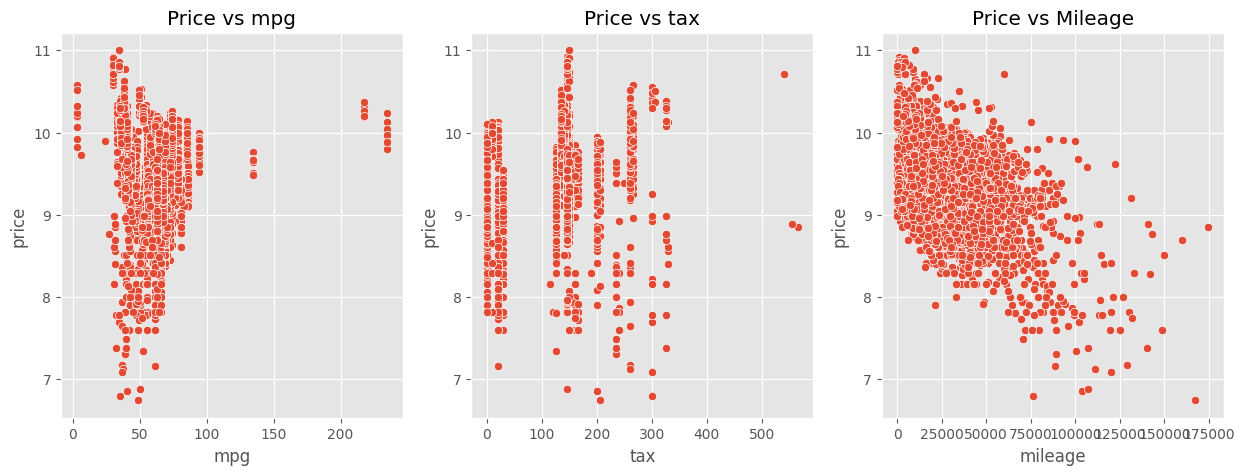

In [12]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.scatterplot(y=df['price'],x=df['mpg'],ax=axes[0]).set(title='Price vs mpg')
sns.scatterplot(y=df['price'],x=df['tax'],ax=axes[1]).set(title='Price vs tax')
sns.scatterplot(y=df['price'],x=df['mileage'],ax=axes[2]).set(title='Price vs Mileage');

In [13]:
# Convert tax variable into an ordinal variable  
df.loc[(df['tax'] <= 100,'tax')] = 1
df.loc[((df['tax'] <= 200) & (df['tax'] > 100) ,'tax')] = 2
df.loc[((df['tax'] <= 300) & (df['tax'] > 200) ,'tax')] = 3
df.loc[(df['tax'] > 300 ,'tax')] = 4

### Categorical Variables - Year, Engine Size, Model, Transmission, fuelType
#### Characteristics about Year, Engine size, Model, Transmission, and fuelType
Since year and engine size is most related to price, I checked their characteristics. From the bar chart below, the most common manufacture year is 2016. Also, the most common engine size in is 1.

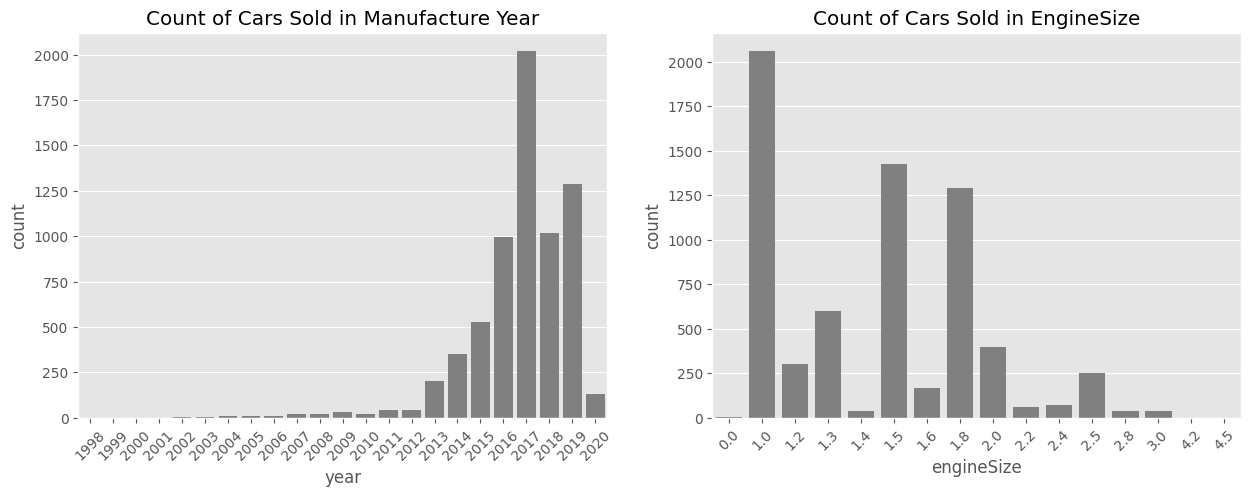

In [14]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x=df['year'], color='gray',ax=axes[0]).set(title='Count of Cars Sold in Manufacture Year')
sns.countplot(x=df['engineSize'],color='gray',ax=axes[1]).set(title='Count of Cars Sold in EngineSize')
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45);

From the bar charts below, we can see the most frequent categories in model, transmission and fuelType variables - Yaris, Manual, Petrol in the dataset. 

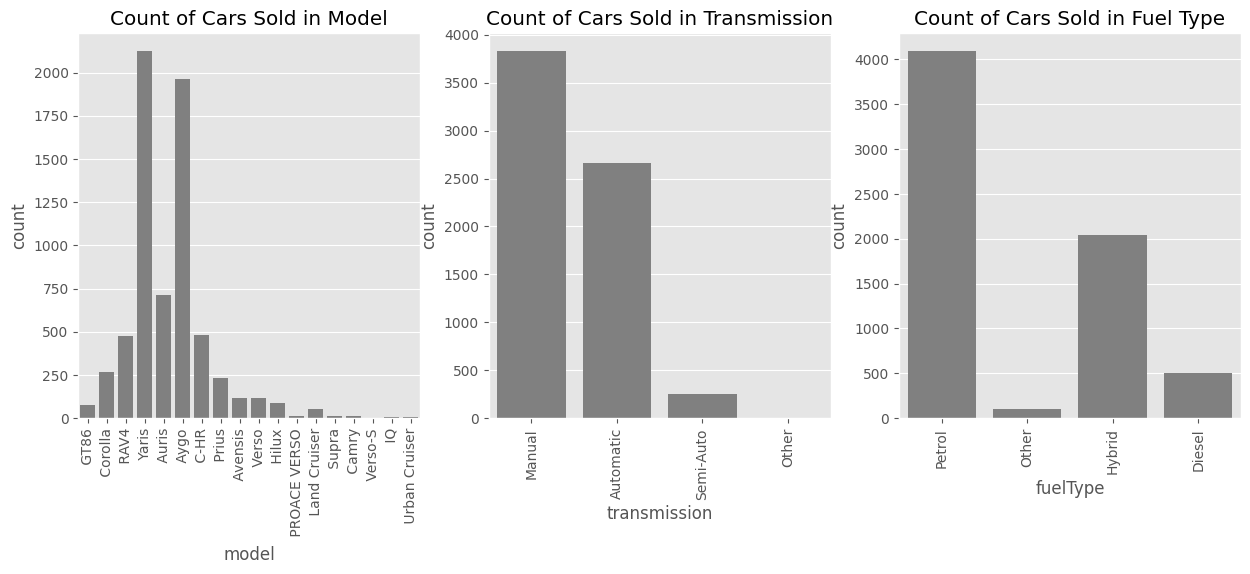

In [15]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x=df['model'],color='gray',ax=axes[0]).set(title='Count of Cars Sold in Model')
sns.countplot(x=df['transmission'],color='gray',ax=axes[1]).set(title='Count of Cars Sold in Transmission')
sns.countplot(x=df['fuelType'],color='gray',ax=axes[2]).set(title='Count of Cars Sold in Fuel Type')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

#### Relationship between Model, Transmission, fuelType and price

I also investigated their relationship between price. From the boxplots below, we can see there is a difference in distribution of prices among each categories in each variable.

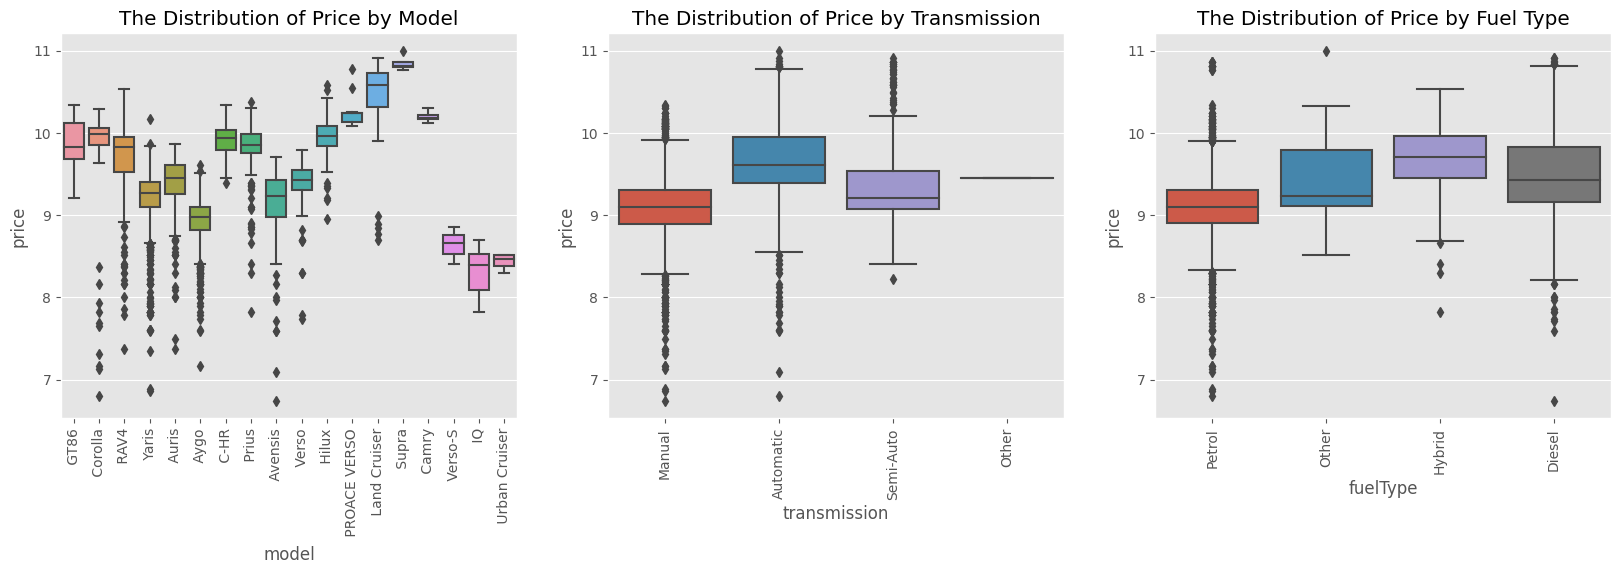

In [16]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(data=df, x='model',y='price',ax=axes[0]).set(title='The Distribution of Price by Model')
sns.boxplot(data=df, x='transmission',y='price',ax=axes[1]).set(title='The Distribution of Price by Transmission')
sns.boxplot(data=df, x='fuelType',y='price',ax=axes[2]).set(title='The Distribution of Price by Fuel Type')
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90);

## Model Fitting & Evaluation
Predicting the price is a regression problem in machine learning. I am choosing the Linear Regression model because we can see strong to moderate relationship between some features and target variable. The comparison model I am choosing is the Decision Tree regression model because it is easy to interpret with independence from outliers.

For the evaluation, I am choosing **R squared** and **RMSE (Root Mean Squared Error)** to evaluate the model. R squared measures how well the model fits dependent variables (i.e. features). RMSE measures how much your predicted results deviate from the actual number. 

### Prepare Data for Modelling
To enable modelling, we chose year,model,transmission,mileage,fuelType,tax,engineSize as features, price as target variables. I also have made the following changes:
- Normalize the numeric features
- Convert the categorical variables into numeric features
- Split the data into a training set and a test set

In [17]:
labelencoder = LabelEncoder()
df['model'] = labelencoder.fit_transform(df['model'])
df['transmission'] = labelencoder.fit_transform(df['transmission'])
df['fuelType'] = labelencoder.fit_transform(df['fuelType'])

In [18]:
feature_cols = ['year','transmission','fuelType','engineSize','tax','model','mileage']
X = df[feature_cols] # Features
y = df['price'] # Target variable

In [19]:
# define the scaler 
scaler = PowerTransformer()
# fit and transform the train set
X[['year','engineSize','mileage']] = scaler.fit_transform(X[['year','engineSize','mileage']])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Linear Regression Model

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
y_pred = lr.predict(X_test)
print('Linear Regression r2_score: ',r2_score(y_test,y_pred))
print('Linear Regression Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,y_pred)))

Linear Regression r2_score:  0.8581849461819505
Linear Regression Root Mean Squared Error:  0.1788722568203105


#### Finding the feature importance

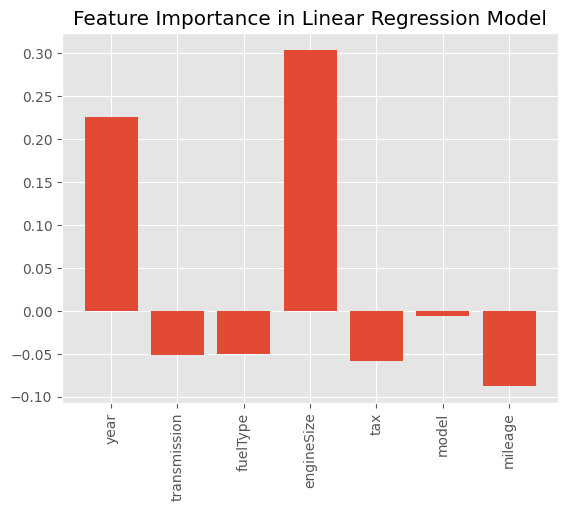

In [23]:
resultdict = {}
for i in range(len(feature_cols)):
    resultdict[feature_cols[i]] = lr.coef_[i]
    
plt.bar(resultdict.keys(),resultdict.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Linear Regression Model');

### Decision Tree Regression Model

In [24]:
tree = DecisionTreeRegressor(max_depth=12,min_samples_split=2,random_state=42)
tree.fit(X_train,y_train)
y_pred2 = tree.predict(X_test)

In [25]:
d_r2 = tree.score(X_test, y_test)
print("Decision Tree Regressor R-squared: {}".format(d_r2))

d_mse = mean_squared_error(y_pred2, y_test)
d_rmse = np.sqrt(d_mse)
print("Decision Tree Regressor RMSE: {}".format(d_rmse))

Decision Tree Regressor R-squared: 0.9373446430064711
Decision Tree Regressor RMSE: 0.11889426976624617


#### Finding the best parameter for Decision Tree Regression Model

Best max_depth is: 12 
Testing R^2 is: 0.9373446430064711


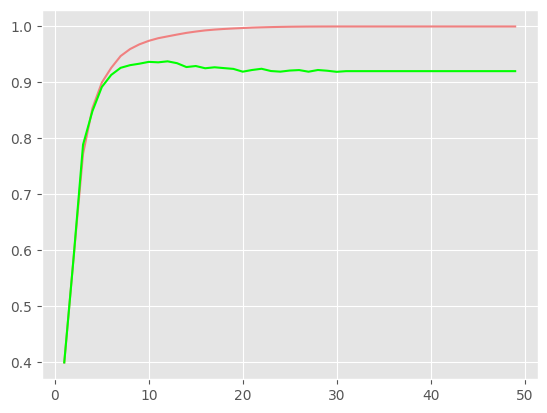

In [26]:
train_score = []
test_score = []
max_score = 0
max_pair = (0,0)

for i in range(1,50):
    tree = DecisionTreeRegressor(max_depth=i,random_state=42)
    tree.fit(X_train,y_train)
    y_pred = tree.predict(X_test)
    train_score.append(tree.score(X_train,y_train))
    test_score.append(r2_score(y_test,y_pred))
    test_pair = (i,r2_score(y_test,y_pred))
    if test_pair[1] > max_pair[1]:
        max_pair = test_pair

fig, ax = plt.subplots()
ax.plot(np.arange(1,50), train_score, label = "Training R^2",color='lightcoral')
ax.plot(np.arange(1,50), test_score, label = "Testing R^2",color='lime')
print(f'Best max_depth is: {max_pair[0]} \nTesting R^2 is: {max_pair[1]}')

#### Finding the feature importance

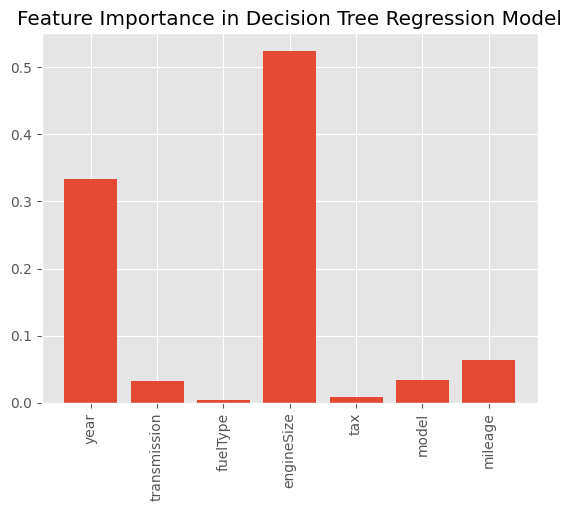

In [27]:
importance = tree.feature_importances_

f_importance = {}
for i in range(len(feature_cols)):
     f_importance[feature_cols[i]] = importance[i]
        
plt.bar(f_importance.keys(),f_importance.values())
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Decision Tree Regression Model');

## Results
The R squared of the Linear Regression, and the Decision Tree Regression model is 0.86 and 0.94, meaning the **Decision Tree Regression model fits the features better.** The RMSE of the Linear Regression, and the Decision Tree Regression model is 0.18 and 0.12, meaning the **Decision Tree Regression model has less error in predicting values.**

### Evaluate by Business Criteria
The company wants to avoid prediction out of a range - more than £1500 higher from actual price. Therefore, we would consider using percentage of predictions which predicted price is not more than £1500 higher than actual price as a KPI to compare the two models again. The higher the percentage, the better the model performs. 90% of the decision tree regressor prediction is not more than £1500 higher than actual sell price, while the linear regression model only have 87%.

In [28]:
X_test['Predicted_price'] = np.round(np.exp(y_pred),0)
X_test['Price'] = np.round(np.exp(y_test),0)
lr_e = X_test

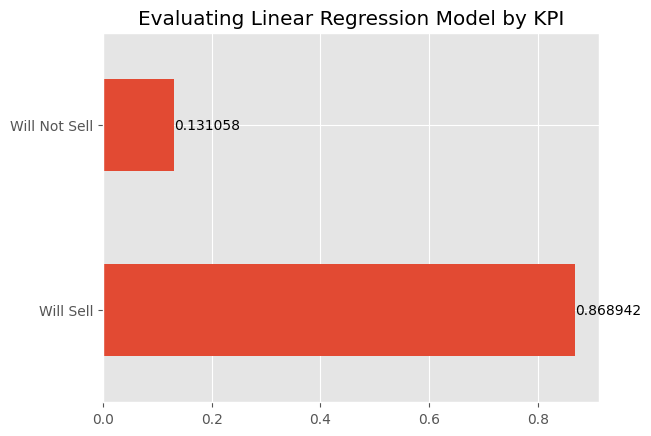

In [29]:
lr_e['Diff'] = lr_e['Predicted_price'] - lr_e['Price']
lr_e['Result'] =  lr_e['Diff'] > 1500
lr_e['Category'] = lr_e['Result'].apply(lambda x: 'Will Not Sell' if x == True else 'Will Sell')
ax = lr_e['Category'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Evaluating Linear Regression Model by KPI');

In [30]:
X_test['Predicted_price'] = np.round(np.exp(y_pred2),0)
X_test['Price'] = np.round(np.exp(y_test),0)
tree_e = X_test

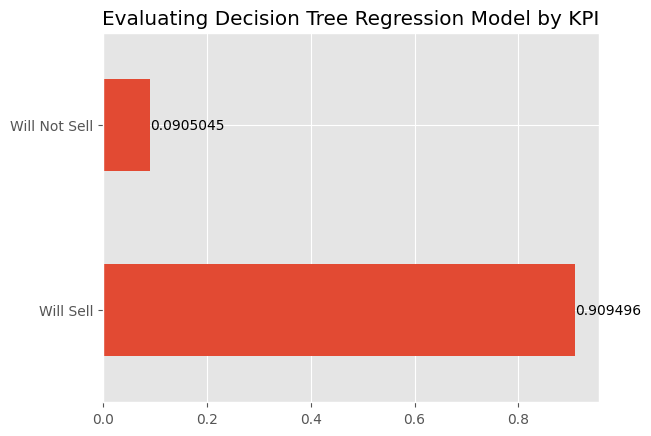

In [31]:
tree_e['Diff'] = tree_e['Predicted_price'] - tree_e['Price']
tree_e['Result'] =  tree_e['Diff'] > 1500
tree_e['Category'] = tree_e['Result'].apply(lambda x: 'Will Not Sell' if x == True else 'Will Sell')
ax = tree_e['Category'].value_counts(normalize=True).plot.barh()
ax.bar_label(ax.containers[0])
ax.set_title('Evaluating Decision Tree Regression Model by KPI');

## Recommendation 

To product, we can deploy this **Logistic Regression Model** into production. By implementing this model, about 82% of the prediction will make sure there is higher traffic on the website. This will help in generating more subscriptions.

To better evaluate whether this model can really help junior salespeople price used cars, I would also recommend A/B testing.

To implement and improve the model:
- I will suggest deploying as web services first since it is the easiest way.

- Collecting more data, e.g. time and economic data, the inflation has a huge influence on the purchasing power
